# Power Analysis for Proportion Metric at Group Size of 500

*A brief exploration of how often one is able to identify significant differences for various effect sizes.  We'll base this around a hypothetical research design where we are looking at how using social media impacts communication with friends and family.*
<br><br>
**Manipulation:** Using Social Media or Not Using Social Media
<br>
**Measurement:** % Answering "Yes" to "Have you communicated with a friend or family member in the past 24 hours?"

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import random

In [2]:
# returns 1 if "Yes" and 0 if "No"
def simulate_response(likelihood_of_yes):
    random_number = random.random()
    if random_number <= likelihood_of_yes:
        return 1
    else:
        return 0

# create a list of responses based on a given likelihood    
def sample_n_responses(sample_size,likelihood_of_yes):
    responses = []
    for i in range(sample_size):
        responses.append(simulate_response(likelihood_of_yes))
    return responses

# get p value comparing two groups with different true likelihoods
def simulate_two_group_test(g1_size, g1_likelihood, g2_size, g2_likelihood):
    group_1 = sample_n_responses(g1_size, g1_likelihood)
    group_2 = sample_n_responses(g2_size, g2_likelihood)
    stats = {
        'group_1_mean': np.mean(group_1),
        'group_2_mean': np.mean(group_2),
        'p_value': sp.stats.ttest_ind(group_1,group_2)[1]
    }
    return stats

# see how often a ttest identifies the correct effect
def estimate_statistical_power(g1_size, g1_likelihood, g2_size, g2_likelihood, simulations=10000, p=.05):
    
    correct_effect_identified_tracker = []
    
    if g1_likelihood == g2_likelihood:
        return "error - input differing likelihoods"
    
    if g1_likelihood > g2_likelihood:
        greater_mean_if_correct = 'group_1_mean'
        lesser_mean_if_correct = 'group_2_mean'
        
    if g2_likelihood > g1_likelihood:
        greater_mean_if_correct = 'group_2_mean'
        lesser_mean_if_correct = 'group_1_mean'
        
    for i in range(simulations):
        
        stats = simulate_two_group_test(g1_size, g1_likelihood, g2_size, g2_likelihood)
        
        if (stats[greater_mean_if_correct] > stats[lesser_mean_if_correct]) & (stats['p_value'] < p):
            correct_effect_identified_tracker.append([1])
            
        else:
            correct_effect_identified_tracker.append([0])
            
    return np.mean(correct_effect_identified_tracker)

    
# run simulations for combinations of specified ranges, return to dataframe
def get_powers_for_ranges(initial_likelihood_range,percentage_point_difference_range,n_per_group,p=.05):
    results = pd.DataFrame()
    for likelihood in initial_likelihood_range:
        for ppdiff in percent_point_difference_range:
            n = n_per_group
            l1 = likelihood
            l2 = likelihood + ppdiff
            power = estimate_statistical_power(n,l1,n,l2,p=p)
            row = {'starting_likelihood':l1, 'percentage_point_difference': ppdiff, 'power': power}
            results = results.append(row, ignore_index= True)
    return results

In [3]:

# let's look at a range of initial likelihoods from 1% to 50%
likelihood1_range = [.01,.05,.1,.15,.2,.25,.3,.4,.5]

# let's look at percentage point differences from 1% to 15%
percent_point_difference_range = [.01,.02,.03,.05,.08,.10,.15]

# we can keep sample size constant at 500
sample_size = 500

results = get_powers_for_ranges(likelihood1_range,percent_point_difference_range,sample_size)


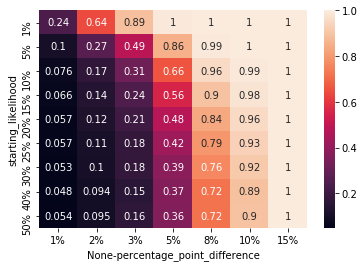

In [4]:
# look at color-coded grid of results
reformatted = results.pivot(index='starting_likelihood', columns='percentage_point_difference')
ax = sns.heatmap(reformatted, annot=True, 
                 xticklabels=['1%','2%','3%','5%','8%','10%','15%'],
                 yticklabels=['1%','5%','10%','15%','20%','25%','30%','40%','50%'])

We reliably have a 90%+ chance of detecting effect sizes of 10 percentage points, with our power to detect effect sizes of 5 percentage points ranging from 36% to 100% depending on the starting likelihood.

Let's run that again except look at how likely we are to hit a p-value of 10%.

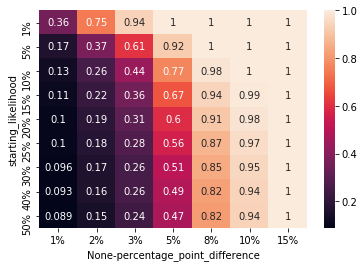

In [5]:
# look at color-coded grid of results
p10_results = get_powers_for_ranges(likelihood1_range,percent_point_difference_range,sample_size,p=.1)
p10_reformatted = p10_results.pivot(index='starting_likelihood', columns='percentage_point_difference')
ax = sns.heatmap(p10_reformatted, annot=True, 
                 xticklabels=['1%','2%','3%','5%','8%','10%','15%'],
                 yticklabels=['1%','5%','10%','15%','20%','25%','30%','40%','50%'])

By adjusting to a p=10% standard, we get some help with 5 percentage point effect sizes, giving us -- at worst -- 50/50 odds.
<br>
Similarly, power is boosted for 10 percentage point effects so we capture them nearly 95% of the time.